# Монтируем все что нужно

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q pyspark

     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 199 kB 58.3 MB/s 


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [ ]:
path = "/content/drive/MyDrive/m5_forecasting"

In [ ]:
my_files = !ls /content/drive/MyDrive/m5_forecasting/

In [ ]:
my_files

['calendar.csv\t\t\t     fourier_features_HOUSEHOLD_CA.parquet',
 'cat_state_date_df.parquet\t     fourier_features_HOUSEHOLD_TX.parquet',
 'fourier_features_FOODS_CA.parquet    fourier_features_HOUSEHOLD_WI.parquet',
 'fourier_features_FOODS_TX.parquet    sales_train_evaluation.csv',
 'fourier_features_FOODS_WI.parquet    sales_train_validation.csv',
 'fourier_features_HOBBIES_CA.parquet  sample_submission.csv',
 'fourier_features_HOBBIES_TX.parquet  sell_prices.csv',
 'fourier_features_HOBBIES_WI.parquet  tmp_spark_hse_sales']

# Готовим данные

In [ ]:
# File location and type
file_calendar = f"{path}/calendar.csv"
file_validation = f"{path}/sales_train_validation.csv"
file_evaluation = f"{path}/sales_train_evaluation.csv"
file_prices = f"{path}/sell_prices.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.


df_validation = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_validation)

df_evaluation = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_evaluation)

df_prices = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_prices)

df_validation.limit(10).toPandas()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,0,0,0,2,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,0,0,1,37,3,4,6,3,2,1
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,0,0,1,1,6,0,0,0,0,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2


In [ ]:
df_calendar = (spark.read.format('csv')
.option('header', 'true')
.option('inferSchema', 'true')
).load(file_calendar)

In [ ]:
df_calendar.limit(10).toPandas()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,None,None,None,None,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,None,None,None,None,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,None,None,None,None,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,None,None,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,None,None,None,None,1,1,0


In [ ]:
df_calendar.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- wm_yr_wk: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- wday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- d: string (nullable = true)
 |-- event_name_1: string (nullable = true)
 |-- event_type_1: string (nullable = true)
 |-- event_name_2: string (nullable = true)
 |-- event_type_2: string (nullable = true)
 |-- snap_CA: integer (nullable = true)
 |-- snap_TX: integer (nullable = true)
 |-- snap_WI: integer (nullable = true)



In [ ]:
print((df_prices.count(), len(df_prices.columns)))

(6841121, 4)


In [ ]:
df_calendar.limit(10).toPandas()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,None,None,None,None,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,None,None,None,None,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,None,None,None,None,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,None,None,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,None,None,None,None,1,1,0


In [ ]:
print((df_calendar.count(), len(df_calendar.columns)))

(1969, 14)


In [ ]:
print(df_validation.count())

30490


In [ ]:
df_validation.limit(10).toPandas()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,0,0,0,2,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,0,0,1,37,3,4,6,3,2,1
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,0,0,1,1,6,0,0,0,0,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2


In [ ]:
# ('id_item', 'day1', 'day2' ... 'day1919')

In [ ]:
# ('id_item', 'day', 'sales')

('id_item', 'store_id', 'day', 'sales')

In [ ]:
# (day, features)

In [ ]:
# (HOBBIES_1_005_CA_1_evaluation, d1, d2, ... d1919)

In [ ]:
# ('HOBBIES_1_005_CA_1_evaluation', 'd1', 0)
# ('HOBBIES_1_005_CA_1_evaluation', 'd2', 1)
# ('HOBBIES_1_005_CA_1_evaluation', 'd3', 0)
# ....
# ('HOBBIES_1_005_CA_1_evaluation', 'd11919', 0)

In [ ]:
import pyspark.sql.functions as F
unpivotExpr = "stack(1, 'd_1', d_1) as (d, sales)"
unPivotDF = df_evaluation.select("id", F.expr(unpivotExpr)) \
    .where("sales is not null")

unPivotDF.show(truncate=False)

+-----------------------------+---+-----+
|id                           |d  |sales|
+-----------------------------+---+-----+
|HOBBIES_1_001_CA_1_evaluation|d_1|0    |
|HOBBIES_1_002_CA_1_evaluation|d_1|0    |
|HOBBIES_1_003_CA_1_evaluation|d_1|0    |
|HOBBIES_1_004_CA_1_evaluation|d_1|0    |
|HOBBIES_1_005_CA_1_evaluation|d_1|0    |
|HOBBIES_1_006_CA_1_evaluation|d_1|0    |
|HOBBIES_1_007_CA_1_evaluation|d_1|0    |
|HOBBIES_1_008_CA_1_evaluation|d_1|12   |
|HOBBIES_1_009_CA_1_evaluation|d_1|2    |
|HOBBIES_1_010_CA_1_evaluation|d_1|0    |
|HOBBIES_1_011_CA_1_evaluation|d_1|0    |
|HOBBIES_1_012_CA_1_evaluation|d_1|0    |
|HOBBIES_1_013_CA_1_evaluation|d_1|0    |
|HOBBIES_1_014_CA_1_evaluation|d_1|0    |
|HOBBIES_1_015_CA_1_evaluation|d_1|4    |
|HOBBIES_1_016_CA_1_evaluation|d_1|5    |
|HOBBIES_1_017_CA_1_evaluation|d_1|0    |
|HOBBIES_1_018_CA_1_evaluation|d_1|0    |
|HOBBIES_1_019_CA_1_evaluation|d_1|0    |
|HOBBIES_1_020_CA_1_evaluation|d_1|0    |
+-----------------------------+---

In [ ]:
import pyspark.sql.functions as F
unpivotExpr = "stack(2, 'd_1', d_1, 'd_2', d_2) as (d, sales)"

unPivotDF = df_evaluation.select("id", F.expr(unpivotExpr))

unPivotDF.show(truncate=False)

+-----------------------------+---+-----+
|id                           |d  |sales|
+-----------------------------+---+-----+
|HOBBIES_1_001_CA_1_evaluation|d_1|0    |
|HOBBIES_1_001_CA_1_evaluation|d_2|0    |
|HOBBIES_1_002_CA_1_evaluation|d_1|0    |
|HOBBIES_1_002_CA_1_evaluation|d_2|0    |
|HOBBIES_1_003_CA_1_evaluation|d_1|0    |
|HOBBIES_1_003_CA_1_evaluation|d_2|0    |
|HOBBIES_1_004_CA_1_evaluation|d_1|0    |
|HOBBIES_1_004_CA_1_evaluation|d_2|0    |
|HOBBIES_1_005_CA_1_evaluation|d_1|0    |
|HOBBIES_1_005_CA_1_evaluation|d_2|0    |
|HOBBIES_1_006_CA_1_evaluation|d_1|0    |
|HOBBIES_1_006_CA_1_evaluation|d_2|0    |
|HOBBIES_1_007_CA_1_evaluation|d_1|0    |
|HOBBIES_1_007_CA_1_evaluation|d_2|0    |
|HOBBIES_1_008_CA_1_evaluation|d_1|12   |
|HOBBIES_1_008_CA_1_evaluation|d_2|15   |
|HOBBIES_1_009_CA_1_evaluation|d_1|2    |
|HOBBIES_1_009_CA_1_evaluation|d_2|0    |
|HOBBIES_1_010_CA_1_evaluation|d_1|0    |
|HOBBIES_1_010_CA_1_evaluation|d_2|0    |
+-----------------------------+---

In [ ]:
print('ok')

ok


In [ ]:
d_columns = [c for c in df_validation.columns if 'd_' in c]
n = len(d_columns)
unpivotExpr = f"stack({n}, " + ','.join([f"'d_{i}', d_{i}" for i in range(1, n+1)]) + ")"+ " as (d, sales)"
unPivotDF = df_evaluation.select("id", "item_id", "store_id", "cat_id", "dept_id", "state_id", F.expr(unpivotExpr))
unPivotDF.show(truncate=False)

+-----------------------------+-------------+--------+-------+---------+--------+----+-----+
|id                           |item_id      |store_id|cat_id |dept_id  |state_id|d   |sales|
+-----------------------------+-------------+--------+-------+---------+--------+----+-----+
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_1 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_2 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_3 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_4 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_5 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_6 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_7 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_

In [ ]:
(unPivotDF.join(df_calendar, on=['d'])
.join(df_prices, on=['item_id', 'store_id', 'wm_yr_wk'])
.cache()
.limit(10)
).toPandas()

,item_id,store_id,wm_yr_wk,d,id,cat_id,dept_id,state_id,sales,date,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_1_001,CA_1,11322,d_876,FOODS_1_001_CA_1_evaluation,FOODS,FOODS_1,CA,2,2013-06-22,...,6,2013,None,None,None,None,0,0,0,2.24
1,FOODS_1_001,CA_1,11322,d_877,FOODS_1_001_CA_1_evaluation,FOODS,FOODS_1,CA,1,2013-06-23,...,6,2013,None,None,None,None,0,0,0,2.24
2,FOODS_1_001,CA_1,11322,d_878,FOODS_1_001_CA_1_evaluation,FOODS,FOODS_1,CA,1,2013-06-24,...,6,2013,None,None,None,None,0,0,0,2.24
3,FOODS_1_001,CA_1,11322,d_879,FOODS_1_001_CA_1_evaluation,FOODS,FOODS_1,CA,0,2013-06-25,...,6,2013,None,None,None,None,0,0,0,2.24
4,FOODS_1_001,CA_1,11322,d_880,FOODS_1_001_CA_1_evaluation,FOODS,FOODS_1,CA,0,2013-06-26,...,6,2013,None,None,None,None,0,0,0,2.24
5,FOODS_1_001,CA_1,11322,d_881,FOODS_1_001_CA_1_evaluation,FOODS,FOODS_1,CA,0,2013-06-27,...,6,2013,None,None,None,None,0,0,0,2.24
6,FOODS_1_001,CA_1,11322,d_882,FOODS_1_001_CA_1_evaluation,FOODS,FOODS_1,CA,10,2013-06-28,...,6,2013,None,None,None,None,0,0,0,2.24
7,FOODS_1_001,CA_2,11433,d_1324,FOODS_1_001_CA_2_evaluation,FOODS,FOODS_1,CA,0,2014-09-13,...,9,2014,None,None,None,None,0,1,0,2.24
8,FOODS_1_001,CA_2,11433,d_1325,FOODS_1_001_CA_2_evaluation,FOODS,FOODS_1,CA,0,2014-09-14,...,9,2014,None,None,None,None,0,0,1,2.24
9,FOODS_1_001,CA_2,11433,d_1326,FOODS_1_001_CA_2_evaluation,FOODS,FOODS_1,CA,2,2014-09-15,...,9,2014,None,None,None,None,0,1,1,2.24


In [ ]:
result = (unPivotDF.join(df_calendar, on=['d'])
.join(df_prices, on=['item_id', 'store_id', 'wm_yr_wk']))

In [ ]:
df_prices.limit(10).toPandas()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


In [ ]:
result = result.withColumn('turnover', F.col('sales')*F.col('sell_price'))

In [ ]:
result.write.mode('overwrite').parquet('./tmp_spark_hse_sales')

In [ ]:
# ! mv ./tmp_spark_hse_sales  ./drive/MyDrive/m5_forecasting/tmp_spark_hse_sales

In [ ]:
result = spark.read.parquet('./drive/MyDrive/m5_forecasting/tmp_spark_hse_sales')

In [ ]:
print(result.count())

45997467


In [ ]:
('cat_id', 'state_id', 'date', 'sales', day_features, prices)

In [ ]:
import pyspark.sql.functions as F

cat_state_date_df = result.groupby(['cat_id',
                'state_id',
                'date', 
                'weekday', 
                'wday', 
                'month', 
                'event_name_1', 
                'event_type_1', 
                'event_name_2', 
                'event_type_2',
                'snap_CA',
                'snap_TX',
                'snap_WI'
                ]).agg(F.sum('sales').alias('sales'))

In [ ]:
cat_state_date_df.cache().write.mode('overwrite').parquet('./drive/MyDrive/m5_forecasting/cat_state_date_df.parquet')

In [ ]:
cat_state_date_df.limit(10).toPandas()

,cat_id,state_id,date,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
0,HOBBIES,WI,2014-06-15,Sunday,2,6,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,647
1,FOODS,CA,2014-11-08,Saturday,1,11,None,None,None,None,1,0,1,12593
2,FOODS,TX,2013-02-08,Friday,7,2,None,None,None,None,1,0,1,6636
3,FOODS,TX,2011-11-28,Monday,3,11,None,None,None,None,0,0,0,4600
4,FOODS,TX,2012-05-17,Thursday,6,5,None,None,None,None,0,0,0,6216
5,FOODS,TX,2012-05-03,Thursday,6,5,None,None,None,None,1,1,1,7389
6,FOODS,WI,2013-01-24,Thursday,6,1,None,None,None,None,0,0,0,5267
7,FOODS,CA,2014-03-24,Monday,3,3,None,None,None,None,0,0,0,9734
8,FOODS,TX,2015-03-19,Thursday,6,3,None,None,None,None,0,0,0,5893
9,FOODS,WI,2015-04-29,Wednesday,5,4,None,None,None,None,0,0,0,5236


# Готовим проект в разрезе Штат/Категория

In [ ]:
cat_state_date_df = spark.read.parquet('./drive/MyDrive/m5_forecasting/cat_state_date_df.parquet')

In [ ]:
import pyspark.sql.functions as F
cat_state_date_df.limit(5).toPandas()

,cat_id,state_id,date,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
0,HOBBIES,WI,2014-06-15,Sunday,2,6,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,647
1,FOODS,CA,2014-11-08,Saturday,1,11,None,None,None,None,1,0,1,12593
2,FOODS,TX,2013-02-08,Friday,7,2,None,None,None,None,1,0,1,6636
3,FOODS,TX,2011-11-28,Monday,3,11,None,None,None,None,0,0,0,4600
4,FOODS,TX,2012-05-17,Thursday,6,5,None,None,None,None,0,0,0,6216


In [ ]:
null, None -> f() -> return  == это означает ничего

In [ ]:
nan -> неопределенность, деление на ноль или то, что нельзя посчитать, возможно близко к ошибке

In [ ]:
cat_state_date_df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in cat_state_date_df.columns]).show()

+------+--------+----+-------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+
|cat_id|state_id|date|weekday|wday|month|event_name_1|event_type_1|event_name_2|event_type_2|snap_CA|snap_TX|snap_WI|sales|
+------+--------+----+-------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+
|     0|       0|   0|      0|   0|    0|           0|           0|           0|           0|      0|      0|      0|    0|
+------+--------+----+-------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+



In [ ]:
cat_state_date_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in cat_state_date_df.columns]).show()

+------+--------+----+-------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+
|cat_id|state_id|date|weekday|wday|month|event_name_1|event_type_1|event_name_2|event_type_2|snap_CA|snap_TX|snap_WI|sales|
+------+--------+----+-------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+
|     0|       0|   0|      0|   0|    0|       15822|       15822|       17172|       17172|      0|      0|      0|    0|
+------+--------+----+-------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+



In [ ]:
cat_state_date_df.select(F.col('event_type_1')).limit(10).show()

+------------+
|event_type_1|
+------------+
|    Sporting|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
+------------+



In [ ]:
cat_state_date_df.select(
    F.when(
        F.isnull(
            F.col('event_type_1')), 1
           ).otherwise(0)
    .alias('event_type_1')
    ).limit(10).show()

+------------+
|event_type_1|
+------------+
|        null|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
+------------+



In [ ]:
when == (if True, 1)
otherwise == иначе (0)

SyntaxError: ignored

In [ ]:
event_type_1.unique() -> 1,2,3

In [ ]:
cat_state_date_df.select(
    F.when(
            F.col('event_type_1') == 1, 'big_event'
           ).otherwise(
              F.when(
                F.col('event_type_1') == 2, 'medium_event'
              ).otherwise('small_event')
           )
    .alias('event_type_1')
    ).limit(10).show()

In [ ]:
import pandas as pd
pd.set_option('max.rows', 100)

In [ ]:
for c in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
  cat_state_date_df = (
      cat_state_date_df
      .withColumn(f"{c}_no_nulls", 
                  F.when(F.isnan(c) | (F.isnull(c)), 
                         'regular_day')
                  .otherwise(F.col(c))
                  )
      )

In [ ]:
cat_state_date_df.limit(5).toPandas()

,cat_id,state_id,date,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales,event_name_1_no_nulls,event_type_1_no_nulls,event_name_2_no_nulls,event_type_2_no_nulls
0,HOBBIES,WI,2014-06-15,Sunday,2,6,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,647,NBAFinalsEnd,Sporting,Father's day,Cultural
1,FOODS,CA,2014-11-08,Saturday,1,11,None,None,None,None,1,0,1,12593,regular_day,regular_day,regular_day,regular_day
2,FOODS,TX,2013-02-08,Friday,7,2,None,None,None,None,1,0,1,6636,regular_day,regular_day,regular_day,regular_day
3,FOODS,TX,2011-11-28,Monday,3,11,None,None,None,None,0,0,0,4600,regular_day,regular_day,regular_day,regular_day
4,FOODS,TX,2012-05-17,Thursday,6,5,None,None,None,None,0,0,0,6216,regular_day,regular_day,regular_day,regular_day


In [ ]:
import pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as F

def vinsorization(df: pyspark.sql.dataframe.DataFrame, 
                  lower_percentile: float = 0.1,
                  higher_percentile: float = 0.9
                  ) -> pyspark.sql.dataframe.DataFrame:

  window_all_df = Window.partitionBy()

  df = (
    df
    .withColumn('10_percentile', F.percentile_approx("sales", lower_percentile, 1_000_000).over(window_all_df))
    .withColumn('90_percentile', F.percentile_approx("sales", higher_percentile, 1_000_000).over(window_all_df))
  )

  df  = (
      df
      .withColumn('sales_visorized', 
                  F.when((F.col('sales') < F.col('90_percentile')) 
                  & 
                  (F.col('sales') > F.col('10_percentile')), 
                  F.col('sales'))
                  )
  )
  return df

# Генерируем признаки

In [ ]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import mean, col

In [ ]:
window_lag = Window.partitionBy(["cat_id", "state_id"]).orderBy("date")

In [ ]:
window_agg = Window.partitionBy(["cat_id", "state_id"]).orderBy("date").rangeBetween(Window.unboundedPreceding, Window.currentRow)

In [ ]:
cat_state_date_df = (
  cat_state_date_df.withColumn("lag_1", F.lag('sales', 1).over(window_lag))
  .withColumn("lag_7", F.lag('sales', 7).over(window_lag))
  .withColumn("mean", F.mean("lag_1").over(window_agg))
)

In [ ]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import mean, col

events = [
          "event_name_1_no_nulls",
          "event_type_1_no_nulls", 
          "event_name_2_no_nulls",
          "event_type_2_no_nulls"
          ]

cat_window_agg = [
                  Window.partitionBy(["cat_id", "state_id", event]).orderBy("date").rangeBetween(Window.unboundedPreceding, Window.currentRow)
                  for event in events
                  ]

window_lag = Window.partitionBy(["cat_id", "state_id"]).orderBy("date")
window_agg = Window.partitionBy(["cat_id", "state_id"]).orderBy("date").rangeBetween(Window.unboundedPreceding, Window.currentRow)

cat_state_date_df = (
  cat_state_date_df.withColumn("lag_1", F.lag('sales', 1).over(window_lag))
  .withColumn("lag_7", F.lag('sales', 7).over(window_lag))
  .withColumn("mean", F.mean("lag_1").over(window_agg))
)

for w, event in zip(cat_window_agg, events):
  cat_state_date_df = cat_state_date_df.withColumn(f"mean_{event}", F.mean("lag_1").over(w))


# Hive timestamp is interpreted as UNIX timestamp in seconds*
days = lambda i: i * 86400 
  
window_lag = Window.partitionBy(["cat_id", "state_id"]).orderBy("date")
window_agg = (Window
              .partitionBy(["cat_id", "state_id"])
              .orderBy(
                  F.col("date").cast("timestamp").cast("long")
                  )
              .rangeBetween(-days(8), -days(1))
              )

cat_state_date_df = (cat_state_date_df.withColumn("mean_7_days", F.mean(F.col('sales')).over(window_agg))).cache()

In [ ]:
cat_state_date_df.cache().limit(5).show()

+---------+--------+----------+---------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+---------------------+---------------------+---------------------+---------------------+-----+-----+------------------+--------------------------+--------------------------+--------------------------+--------------------------+------------------+
|   cat_id|state_id|      date|  weekday|wday|month|event_name_1|event_type_1|event_name_2|event_type_2|snap_CA|snap_TX|snap_WI|sales|event_name_1_no_nulls|event_type_1_no_nulls|event_name_2_no_nulls|event_type_2_no_nulls|lag_1|lag_7|              mean|mean_event_name_1_no_nulls|mean_event_type_1_no_nulls|mean_event_name_2_no_nulls|mean_event_type_2_no_nulls|       mean_7_days|
+---------+--------+----------+---------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+---------------------+---------------------+---------------------+---------------------+-----+-----+----

In [ ]:
print('ok')

ok


In [ ]:
Дорогая категория - продалось 10 шт а мы предсказали 100 -- ошибка 90 - в 10 раз -- 90/10  * 100 -- 900%
Дешевая категория - продалось 2000 а мы предсказали 3000 -- ошибка 1000  - в 1,5 раза --- 1000/2000 -- 0.5 -- 50%


1) Что лучше перепредсказать или недопредсказать?
2) Различаются ли дорогая категория и Дешевая

Насколько хуже если мы предскажем на 1000 больше икры или на 1000 больше картошки - есть разница?

SyntaxError: ignored

In [ ]:
MSE, MAE -- в штуках

In [ ]:
MAPE -- Mean percentage error

# Baseline

In [ ]:
import pyspark
import typing as tp

#Почему такая большая ошибка в некоторых строках?

def count_mape(df: pyspark.sql.dataframe.DataFrame, 
               prediction_col: str ='prediction', 
               sales_col: str = 'sales', 
               group: tp.List[str] = ['cat_id', 'state_id']
               ) -> pyspark.sql.dataframe.DataFrame:
  return (
      (df
       .withColumn('abs_error', F.abs((F.col(sales_col) - F.col(prediction_col))))
       .withColumn('divided_by_sales', F.col('abs_error')/F.col(sales_col) * 100)
       )
  .groupby(group)
  .agg(
      F.sum(F.col('divided_by_sales')).alias('sum_error'),
      F.count(F.col('divided_by_sales')).alias('cnt')
      )
  .withColumn('MAPE', F.col('sum_error')/F.col('cnt'))
  )

In [ ]:
count_mape(cat_state_date_df, prediction_col='lag_7').cache().limit(10).toPandas()

,cat_id,state_id,sum_error,cnt,MAPE
0,HOUSEHOLD,TX,2.002369e+04,1900,10.538786
1,HOUSEHOLD,WI,2.727835e+05,1901,143.494744
2,HOBBIES,CA,2.442203e+04,1900,12.853698
3,FOODS,TX,9.649229e+05,1905,506.521201
4,HOBBIES,TX,2.556257e+04,1900,13.453984
5,HOBBIES,WI,3.219584e+04,1900,16.945177
6,HOUSEHOLD,CA,1.679913e+04,1900,8.841646
7,FOODS,CA,7.884954e+05,1905,413.908325
8,FOODS,WI,1.634863e+06,1905,858.196013


In [ ]:
count_mape(cat_state_date_df, prediction_col='mean').cache().limit(10).toPandas()

,cat_id,state_id,sum_error,cnt,MAPE
0,HOUSEHOLD,TX,3.704510e+04,1906,19.436041
1,HOUSEHOLD,WI,2.275703e+05,1907,119.334175
2,HOBBIES,CA,3.265935e+04,1906,17.135020
3,FOODS,TX,9.263938e+05,1911,484.769138
4,HOBBIES,TX,3.348419e+04,1906,17.567779
5,HOBBIES,WI,3.584306e+04,1906,18.805385
6,HOUSEHOLD,CA,3.589411e+04,1906,18.832168
7,FOODS,CA,8.040599e+05,1911,420.753490
8,FOODS,WI,1.532933e+06,1911,802.162728


In [ ]:
count_mape(cat_state_date_df, prediction_col='mean_7_days').cache().limit(10).toPandas()

,cat_id,state_id,sum_error,cnt,MAPE
0,HOUSEHOLD,TX,2.761679e+04,1906,14.489396
1,HOUSEHOLD,WI,2.770389e+05,1907,145.274735
2,HOBBIES,CA,2.481928e+04,1906,13.021657
3,FOODS,TX,9.948280e+05,1911,520.579792
4,HOBBIES,TX,2.704634e+04,1906,14.190106
5,HOBBIES,WI,3.431237e+04,1906,18.002291
6,HOUSEHOLD,CA,3.034398e+04,1906,15.920243
7,FOODS,CA,8.374699e+05,1911,438.236452
8,FOODS,WI,1.734028e+06,1911,907.392928


In [ ]:
count_mape(cat_state_date_df, prediction_col='lag_1').cache().limit(10).toPandas()

,cat_id,state_id,sum_error,cnt,MAPE
0,HOUSEHOLD,TX,2.749538e+04,1906,14.425699
1,HOUSEHOLD,WI,2.783104e+05,1907,145.941499
2,HOBBIES,CA,2.762342e+04,1906,14.492875
3,FOODS,TX,1.099622e+06,1911,575.417232
4,HOBBIES,TX,3.139092e+04,1906,16.469529
5,HOBBIES,WI,3.986576e+04,1906,20.915927
6,HOUSEHOLD,CA,2.904694e+04,1906,15.239739
7,FOODS,CA,7.771751e+05,1911,406.685024
8,FOODS,WI,1.789791e+06,1911,936.573005


# Строим модель

In [ ]:
cat_state_date_df.limit(5).show()

+---------+--------+----------+---------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+---------------------+---------------------+---------------------+---------------------+-----+-----+------------------+--------------------------+--------------------------+--------------------------+--------------------------+------------------+
|   cat_id|state_id|      date|  weekday|wday|month|event_name_1|event_type_1|event_name_2|event_type_2|snap_CA|snap_TX|snap_WI|sales|event_name_1_no_nulls|event_type_1_no_nulls|event_name_2_no_nulls|event_type_2_no_nulls|lag_1|lag_7|              mean|mean_event_name_1_no_nulls|mean_event_type_1_no_nulls|mean_event_name_2_no_nulls|mean_event_type_2_no_nulls|       mean_7_days|
+---------+--------+----------+---------+----+-----+------------+------------+------------+------------+-------+-------+-------+-----+---------------------+---------------------+---------------------+---------------------+-----+-----+----

In [ ]:
df_val = cat_state_date_df.where(F.col('date') > '2015-04-23')
df_train = cat_state_date_df.where(F.col('date') <= '2015-04-23')

In [ ]:
df_val = df_val.fillna(0)

In [ ]:
df_train = df_train.fillna(0)

In [ ]:
FEATURES_COL = [
                'lag_1',
                'lag_7',
                'mean',
                'mean_event_name_1_no_nulls',
                'mean_event_type_1_no_nulls',
                'mean_event_name_2_no_nulls', 
                'mean_event_type_2_no_nulls',
                'mean_7_days',
                # 'furier'
                ]
LABEL_COL = 'sales'

In [ ]:
# cat_state_date_df = cat_state_date_df.na.drop()

In [ ]:
df_train, df_val = cat_state_date_df.randomSplit([0.7, 0.3], 42)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

#stage 1
assembler = VectorAssembler(inputCols=FEATURES_COL, outputCol='features')

#stage 2
lr = LinearRegression(featuresCol='features', labelCol=LABEL_COL, maxIter=10)

stages = [assembler, lr]
p = Pipeline(stages=stages)

In [ ]:
pipeline_trained = p.fit(df_train)
predicted_dataframe = pipeline_trained.transform(df_val)

In [ ]:
# predicted_dataframe.limit(5).toPandas()

In [ ]:
count_mape(cat_state_date_df, prediction_col='lag_7').cache().limit(10).toPandas()

,cat_id,state_id,sum_error,cnt,MAPE
0,HOUSEHOLD,TX,2.002369e+04,1900,10.538786
1,HOUSEHOLD,WI,2.727835e+05,1901,143.494744
2,HOBBIES,CA,2.442203e+04,1900,12.853698
3,FOODS,TX,9.649229e+05,1905,506.521201
4,HOBBIES,TX,2.556257e+04,1900,13.453984
5,HOBBIES,WI,3.219584e+04,1900,16.945177
6,HOUSEHOLD,CA,1.679913e+04,1900,8.841646
7,FOODS,CA,7.884954e+05,1905,413.908325
8,FOODS,WI,1.634863e+06,1905,858.196013


In [ ]:
count_mape(predicted_dataframe, prediction_col='prediction').cache().limit(10).toPandas()

,cat_id,state_id,sum_error,cnt,MAPE
0,HOUSEHOLD,TX,3140.210087,365,8.603315
1,HOUSEHOLD,WI,236055.280609,366,644.959783
2,HOBBIES,CA,3293.503002,365,9.023296
3,FOODS,TX,157399.698033,366,430.053820
4,HOBBIES,TX,3631.138287,365,9.948324
5,HOBBIES,WI,4752.859679,365,13.021533
6,HOUSEHOLD,CA,3374.202333,365,9.244390
7,FOODS,CA,149640.359854,366,408.853442
8,FOODS,WI,241906.355905,366,660.946328


# Считаем метрики

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='sales', metricName="")
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='sales', metricName="r2")

print(rmse_evaluator.evaluate(predicted_dataframe))
print(r2_evaluator.evaluate(predicted_dataframe))

764.4012888227396
0.9510757313121768


In [ ]:
r2_evaluator.evaluate(predicted_dataframe.withColumn('prediction', F.col('mean')).fillna(0))

0.8563313998055175

In [ ]:
result.groupBy('store_id', 'date').agg(F.sum(F.col('turnover')).alias('sum_store_turnover')).write.mode('overwrite').parquet('./tmp_stores_turnover.parquet')

In [ ]:
from pyspark.sql.window import Window
import pyspark.sql.functions  as F

window_lag = Window.partitionBy("store_id").orderBy("date")
window_agg = Window.partitionBy("store_id").orderBy("date").rangeBetween(Window.unboundedPreceding, Window.currentRow)

sales_stores = (
  sales_stores.withColumn("lag_1", F.lag('sum_store_sales', 1).over(window_lag))
 .withColumn("lag_2", F.lag('sum_store_sales', 2).over(window_lag))
 .withColumn("lag_3", F.lag('sum_store_sales', 3).over(window_lag))
 .withColumn("lag_4", F.lag('sum_store_sales', 4).over(window_lag))
 .withColumn("lag_5", F.lag('sum_store_sales', 5).over(window_lag))
 .withColumn("lag_6", F.lag('sum_store_sales', 6).over(window_lag))
 .withColumn("lag_7", F.lag('sum_store_sales', 7).over(window_lag))
 .withColumn("mean", F.mean("lag_1").over(window_agg))
)

In [ ]:
sales_stores.cache().limit(10).toPandas()

Out[68]:

,store_id,date,sum_store_sales,lag_1,lag_2,lag_3,lag_4,lag_5,mean,lag_6,lag_7
0,WI_2,2011-01-29,2256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WI_2,2011-01-30,1922.0,2256.0,NaN,NaN,NaN,NaN,2256.000000,NaN,NaN
2,WI_2,2011-01-31,2018.0,1922.0,2256.0,NaN,NaN,NaN,2089.000000,NaN,NaN
3,WI_2,2011-02-01,2522.0,2018.0,1922.0,2256.0,NaN,NaN,2065.333333,NaN,NaN
4,WI_2,2011-02-02,1175.0,2522.0,2018.0,1922.0,2256.0,NaN,2179.500000,NaN,NaN
5,WI_2,2011-02-03,2244.0,1175.0,2522.0,2018.0,1922.0,2256.0,1978.600000,NaN,NaN
6,WI_2,2011-02-04,2232.0,2244.0,1175.0,2522.0,2018.0,1922.0,2022.833333,2256.0,NaN
7,WI_2,2011-02-05,2643.0,2232.0,2244.0,1175.0,2522.0,2018.0,2052.714286,1922.0,2256.0
8,WI_2,2011-02-06,2140.0,2643.0,2232.0,2244.0,1175.0,2522.0,2126.500000,2018.0,1922.0
9,WI_2,2011-02-07,1836.0,2140.0,2643.0,2232.0,2244.0,1175.0,2128.000000,2522.0,2018.0


In [ ]:
df_train, df_test = sales_stores.fillna(0).randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='sum_store_sales', metricName="rmse")
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='sum_store_sales', metricName="r2")

rmse_evaluator.evaluate(sales_stores.withColumn('prediction', F.col('lag_1')).fillna(0))

Out[24]: 722.1083186401971

In [ ]:
r2_evaluator.evaluate(sales_stores.withColumn('prediction', F.col('lag_1')).fillna(0))

Out[27]: 0.6976463358489227

In [ ]:
r2_evaluator.evaluate(sales_stores.withColumn('prediction', F.col('mean')).fillna(0))

Out[28]: 0.519866790394214

In [ ]:
LABEL_COL = 'sum_store_sales'

In [ ]:
FEATURES_COL = [i for i in sales_stores.columns if i not in [LABEL_COL, 'store_id', 'date']]

In [ ]:
FEATURES_COL

Out[34]: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'mean']

In [ ]:
df_train

Out[73]: DataFrame[store_id: string, date: string, sum_store_sales: double, lag_1: double, lag_2: double, lag_3: double, lag_4: double, lag_5: double, mean: double, lag_6: double, lag_7: double]

In [ ]:
learnt_pipeline = p.fit(df_train)

In [ ]:
df_predictions = learnt_pipeline.transform(df_train)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
 
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='sum_store_sales', metricName="rmse")
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='sum_store_sales', metricName="r2")
 
# rmse_evaluator

In [ ]:
0.77

In [ ]:
r2_evaluator.evaluate(df_predictions)

Out[76]: 0.7777886116653201

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
(df_predictions.withColumn('abserror_divided', 
                          F.abs(F.col('sum_store_sales') - F.col('prediction'))
                          /F.col('sum_store_sales') * F.lit(100))
 .where(F.col('date') != '2011-12-25')
 .where(F.col('date') != '2012-12-25')
 .where(F.col('date') != '2013-12-25')
 .where(F.col('date') != '2014-12-25')
 .where(F.col('date') != '2015-12-25')
 .groupBy('store_id').agg(F.mean(F.col('abserror_divided')).alias('MAPE'))
).show()

+--------+------------------+
store_id| MAPE|
+--------+------------------+
 WI_2|14.833187373097042|
 WI_3|15.497858753534588|
 TX_2|15.286317185982748|
 WI_1|16.122978602778197|
 TX_1| 13.83764610260351|
 CA_4| 9.376478505193804|
 TX_3|11.646472682475604|
 CA_2|15.714942231303485|
 CA_1|13.016261134251609|
 CA_3| 9.840401046673652|
+--------+------------------+

In [ ]:
df_predictions.where(F.col('store_id')=='CA_3').where((F.col('date') > '2011-12-20')).where((F.col('date') < '2011-12-31')).limit(10).toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field vec_lag_1. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[118]:

,store_id,date,sum_store_sales,lag_1,lag_2,lag_3,lag_4,lag_5,mean,lag_6,lag_7,vec_lag_1,vec_lag_2,vec_lag_3,vec_lag_4,vec_lag_5,vec_mean,scaled_lag_1,scaled_lag_2,scaled_lag_3,scaled_lag_4,scaled_lag_5,scaled_mean,features,prediction
0,CA_3,2011-12-22,4639.0,4347.0,4424.0,4973.0,5573.0,5648.0,4511.253823,4980.0,4906.0,[4347.0],[4424.0],[4973.0],[5573.0],[5648.0],[4511.253822629969],[0.6916797235211495],[0.7563820768613331],[1.1740812139042673],[1.6313748079090806],[1.6919997462424512],[1.4874850215362754],"[0.6916797235211495, 0.7563820768613331, 1.174...",4705.629448
1,CA_3,2011-12-23,5820.0,4639.0,4347.0,4424.0,4973.0,5573.0,4511.643293,5648.0,4980.0,[4639.0],[4347.0],[4424.0],[4973.0],[5573.0],[4511.643292682927],[0.9123544208817822],[0.6981884865774628],[0.7597795844188321],[1.1768577963432902],[1.6351178341394175],[1.487878977089611],"[0.9123544208817822, 0.6981884865774628, 0.759...",4963.838127
2,CA_3,2011-12-25,1.0,4753.0,5820.0,4639.0,4347.0,4424.0,4516.339394,4973.0,5573.0,[4753.0],[5820.0],[4639.0],[4347.0],[4424.0],[4516.339393939394],[0.998508241084221],[1.8114243110987733],[0.9220288564395399],[0.702645047609649],[0.7636869407209436],[1.4926291630280795],"[0.998508241084221, 1.8114243110987733, 0.9220...",4540.973520
3,CA_3,2011-12-27,4530.0,4998.0,1.0,4753.0,5820.0,4639.0,4504.189759,4347.0,4424.0,[4998.0],[1.0],[4753.0],[5820.0],[4639.0],[4504.189759036145],[1.1836633809929709],[-2.5863484403537087],[1.008058702999357],[1.8184843110036644],[0.9267484220829731],[1.4803396015976356],"[1.1836633809929709, -2.5863484403537087, 1.00...",5816.372248
4,CA_3,2011-12-28,4745.0,4530.0,4998.0,1.0,4753.0,5820.0,4504.267267,4639.0,4347.0,[4530.0],[4998.0],[1.0],[4753.0],[5820.0],[4504.267267267267],[0.8299792770040118],[1.1901888407956387],[-2.578027532546704],[1.010201558769167],[1.8224489313320746],[1.480418002485837],"[0.8299792770040118, 1.1901888407956387, -2.57...",4581.203196
5,CA_3,2011-12-30,6115.0,4511.0,4745.0,4530.0,4998.0,1.0,4505.005970,4753.0,5820.0,[4511.0],[4745.0],[4530.0],[4998.0],[1.0],[4505.005970149254],[0.815620306970272],[0.9989813298629221],[0.8397722487639252],[1.1957960051585315],[-2.5908290223686214],[1.4811652129591817],"[0.815620306970272, 0.9989813298629221, 0.8397...",3380.923630


In [ ]:
df_predictions.withColumn('abserror_divided', 
                          F.abs(F.col('sum_store_sales') - F.col('prediction'))
                          /F.col('sum_store_sales') * F.lit(100)).where(F.col('store_id')=='CA_3').orderBy(F.col('abserror_divided').desc()).limit(10).toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field vec_lag_1. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[110]:

,store_id,date,sum_store_sales,lag_1,lag_2,lag_3,lag_4,lag_5,mean,lag_6,lag_7,vec_lag_1,vec_lag_2,vec_lag_3,vec_lag_4,vec_lag_5,vec_mean,scaled_lag_1,scaled_lag_2,scaled_lag_3,scaled_lag_4,scaled_lag_5,scaled_mean,features,prediction,abserror_divided
0,CA_3,2011-12-25,1.0,4753.0,5820.0,4639.0,4347.0,4424.0,4516.339394,4973.0,5573.0,[4753.0],[5820.0],[4639.0],[4347.0],[4424.0],[4516.339393939394],[0.998508241084221],[1.8114243110987733],[0.9220288564395399],[0.702645047609649],[0.7636869407209436],[1.4926291630280795],"[0.998508241084221, 1.8114243110987733, 0.9220...",4540.973520,453997.352007
1,CA_3,2013-12-25,3.0,4594.0,5727.0,6615.0,6147.0,4985.0,5498.894439,5056.0,5255.0,[4594.0],[5727.0],[6615.0],[6147.0],[4985.0],[5498.894439208294],[0.8783463339597668],[1.7411385462104625],[2.41321286347637],[2.06619608230702],[1.1891636432516346],[2.486500228601909],"[0.8783463339597668, 1.7411385462104625, 2.413...",4766.837845,158794.594838
2,CA_3,2012-12-25,4.0,5451.0,5929.0,6147.0,4959.0,4910.0,5155.589080,4495.0,5173.0,[5451.0],[5929.0],[6147.0],[4959.0],[4910.0],[5155.58908045977],[1.526011456007925],[1.8938022505915248],[2.0600377039150155],[1.1662523994067553],[1.132281731148601],[2.1392410451500314],"[1.526011456007925, 1.8938022505915248, 2.0600...",5351.933932,133698.348305
3,CA_3,2015-12-25,4.0,4167.0,5353.0,5431.0,5158.0,6470.0,5822.939698,6408.0,5074.0,[4167.0],[5353.0],[5431.0],[5158.0],[6470.0],[5822.939698492462],[0.5556473758330882],[1.458483964831664],[1.5197098956972168],[1.3170005415760757],[2.315425502891699],[2.8142774953206047],"[0.5556473758330882, 1.458483964831664, 1.5197...",5076.212744,126805.318606
4,CA_3,2011-01-29,4739.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-2.5935014731455293],[-2.587104201266486],[-2.578782180323545],[-2.5903307011845023],[-2.5915874478633287],[-3.0757246076445623],"[-2.5935014731455293, -2.587104201266486, -2.5...",114.077522,97.592793
5,CA_3,2013-03-31,3352.0,7036.0,5651.0,4924.0,4912.0,4907.0,5201.369949,5056.0,6295.0,[7036.0],[5651.0],[4924.0],[4912.0],[4907.0],[5201.36994949495],[2.723851850927798],[1.6837007168393698],[1.1371034728390828],[1.1306485668341015],[1.1300064546644797],[2.185549169371649],"[2.723851850927798, 1.6837007168393698, 1.1371...",6511.539305,94.258332
6,CA_3,2012-12-26,4987.0,4.0,5451.0,5929.0,6147.0,4959.0,5148.197991,4910.0,4495.0,[4.0],[5451.0],[5929.0],[6147.0],[4959.0],[5148.197991391678],[-2.5904785320857946],[1.5325485342838625],[1.8955244885637863],[2.06619608230702],[1.1694445803892495],[2.1317648334067543],"[-2.5904785320857946, 1.5325485342838625, 1.89...",1336.682608,73.196659
7,CA_3,2015-12-26,5918.0,4.0,4167.0,5353.0,5431.0,5158.0,5819.692522,6470.0,6408.0,[4.0],[4167.0],[5353.0],[5431.0],[5158.0],[5819.692522321428],[-2.5904785320857946],[0.5621515222775063],[1.4608473691036576],[1.5238057818385102],[1.3203712538359653],[2.810992921640228],"[-2.5904785320857946, 0.5621515222775063, 1.46...",1932.138251,67.351500
8,CA_3,2013-11-28,3369.0,5365.0,5517.0,5224.0,6704.0,6517.0,5493.253385,5387.0,4982.0,[5365.0],[5517.0],[5224.0],[6704.0],[6517.0],[5493.2533849129595],[1.461018223223629],[1.58242875452718],[1.363497805891233],[2.4881393747105953],[2.351071501142933],[2.4807942066640445],"[1.461018223223629, 1.58242875452718, 1.363497...",5601.755323,66.273533
9,CA_3,2011-02-14,3303.0,5780.0,5187.0,4380.0,4406.0,4544.0,4697.812500,4447.0,4912.0,[5780.0],[5187.0],[4380.0],[4406.0],[4544.0],[4697.8125],[1.7746483581711037],[1.333027653310593],[0.7265750822378501],[0.7473392204136184],[0.8546980000857972],[1.67619228263334],"[1.7746483581711037, 1.333027653310593, 0.7265...",5485.548361,66.077758


In [ ]:
df_predictions.count()

Out[62]: 13311

# Добавляем знание о сезонности

In [ ]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import StringType

In [ ]:
## UDF
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

columns = ["Seqno","Name"]
data = [("1", "john jones"),
    ("2", "tracey smith"),
    ("3", "amy sanders")]

df = spark.createDataFrame(data=data,schema=columns)

df.show(truncate=False)

In [ ]:
#Ваирант 1
def udf_upper_names(x: str) -> str:
  step_2 = x.split()
  return ' '.join([word[0].upper() + word[1:] for word in step_2])

udf_upper_namesUDF = f.udf(lambda z: udf_upper_names(z)) 

df.select(f.col("Seqno"), \
    udf_upper_namesUDF(f.col("Name")).alias("Name") ) \
.show(truncate=False)

In [ ]:
x = 'john jones'
step_2 = x.split()

In [ ]:
' '.join([word[0].upper() + word[1:] for word in step_2])

In [ ]:
#Вариант 2
""" Converting function to UDF """
@f.udf() 
def udf_upper_names(x: str) -> str:
  step_2 = x.split()
  return ' '.join([word[0].upper() + word[1:] for word in step_2])


df.select(f.col("Seqno"), \
    udf_upper_names(f.col("Name")).alias("Name") ) \
.show(truncate=False)

In [ ]:
#Ваирант 3
def udf_upper_names(x: str) -> str:
  step_2 = x.split()
  return ' '.join([word[0].upper() + word[1:] for word in step_2])

udf_upper_namesUDF = f.udf(udf_upper_names) 

df.select(f.col("Seqno"), \
    udf_upper_namesUDF(f.col("Name")).alias("Name") ) \
.show(truncate=False)

In [ ]:
import numpy as np
import pylab as pl
from numpy import fft

In [ ]:
cat_state_date_df.limit(5).toPandas()

,state_id,cat_id,date,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales,sales,furier
0,WI,HOBBIES,2014-06-15,Sunday,2,6,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,647,647,770.635871
1,WI,HOBBIES,2014-06-15,Sunday,2,6,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,647,647,770.635871
2,CA,FOODS,2014-11-08,Saturday,1,11,None,None,None,None,1,0,1,12593,12593,9973.136401
3,TX,FOODS,2013-02-08,Friday,7,2,None,None,None,None,1,0,1,6636,6636,6803.451355
4,TX,FOODS,2011-11-28,Monday,3,11,None,None,None,None,0,0,0,4600,4600,6254.399552


In [ ]:
def fourierlearn(x):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))


In [ ]:
def fourier_apply(n_predict, p, f, x_freqdom):
  n_harm = 10  
  t = np.arange(0, n + n_predict)

In [ ]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    print(f"frequencies:{f}")
    print(f"detrended x in frequency domain:{x_freqdom}")
    print(f"sort indexes by frequency, lower -> higher: {indexes[:1 + n_harm * 2]}")
    return

In [ ]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [ ]:
x = one_ts['sales'].values
x = x[:1546]
n_predict = 1912 - 1546
extrapolation = fourierExtrapolation(x, n_predict)

In [ ]:
cat_state_date_df.select('cat_id').distinct().show()

+---------+
|   cat_id|
+---------+
|    FOODS|
|HOUSEHOLD|
|  HOBBIES|
+---------+



In [ ]:
from itertools import product
list(product(['HOBBIES', 'FOODS', 'HOUSEHOLD'], 
             ['WI', 'CA', 'TX']))

[('HOBBIES', 'WI'),
 ('HOBBIES', 'CA'),
 ('HOBBIES', 'TX'),
 ('FOODS', 'WI'),
 ('FOODS', 'CA'),
 ('FOODS', 'TX'),
 ('HOUSEHOLD', 'WI'),
 ('HOUSEHOLD', 'CA'),
 ('HOUSEHOLD', 'TX')]

In [ ]:
from itertools import product

for category, state in product(
    ['HOBBIES', 'FOODS', 'HOUSEHOLD'], 
             ['WI', 'CA', 'TX']):
  
  print(category, state)
  
  one_ts = (cat_state_date_df.where(
     (F.col('cat_id') == category) & (F.col('state_id') == state))
  ).toPandas()
  
  one_ts = one_ts.sort_values(by=['date'])[['cat_id', 'state_id', 'date', 'sales']].reset_index(drop=True)

  x = one_ts['sales'].values
  x = x[:1546]
  n_predict = 1912 - 1546
  extrapolation = fourierExtrapolation(x, n_predict)

  one_ts["furier"] = extrapolation

  one_ts_spark = spark.createDataFrame(one_ts)

  one_ts_spark.write.mode('overwrite').parquet(f'./drive/MyDrive/m5_forecasting/fourier_features_{category}_{state}.parquet')


HOBBIES WI
HOBBIES CA
HOBBIES TX
FOODS WI
FOODS CA
FOODS TX
HOUSEHOLD WI
HOUSEHOLD CA
HOUSEHOLD TX


In [ ]:
for category, state in product(
    ['HOBBIES', 'FOODS', 'HOUSEHOLD'], 
             ['WI', 'CA', 'TX']):
  if category=='HOBBIES' and state=='WI':
    tmp1 = spark.read.parquet(f'./drive/MyDrive/m5_forecasting/fourier_features_{category}_{state}.parquet')
  else:
    tmp1 = tmp1.union(spark.read.parquet(f'./drive/MyDrive/m5_forecasting/fourier_features_{category}_{state}.parquet'))


In [ ]:
cat_state_date_df = cat_state_date_df.join(tmp1.select('state_id', 'cat_id', 'date', 'furier'), on=['state_id', 'cat_id', 'date'])

In [ ]:
cat_state_date_df.limit(10).toPandas()

,state_id,cat_id,date,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales,furier
0,WI,HOBBIES,2014-06-15,Sunday,2,6,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,647,770.635871
1,CA,FOODS,2014-11-08,Saturday,1,11,None,None,None,None,1,0,1,12593,9973.136401
2,TX,FOODS,2013-02-08,Friday,7,2,None,None,None,None,1,0,1,6636,6803.451355
3,TX,FOODS,2011-11-28,Monday,3,11,None,None,None,None,0,0,0,4600,6254.399552
4,TX,FOODS,2012-05-17,Thursday,6,5,None,None,None,None,0,0,0,6216,7617.823061
5,TX,FOODS,2012-05-03,Thursday,6,5,None,None,None,None,1,1,1,7389,7533.914827
6,WI,FOODS,2013-01-24,Thursday,6,1,None,None,None,None,0,0,0,5267,7780.590466
7,CA,FOODS,2014-03-24,Monday,3,3,None,None,None,None,0,0,0,9734,10625.155557
8,TX,FOODS,2015-03-19,Thursday,6,3,None,None,None,None,0,0,0,5893,6787.620126
9,WI,FOODS,2015-04-29,Wednesday,5,4,None,None,None,None,0,0,0,5236,7865.381434


In [ ]:
foods_ca = spark.read.parquet('./drive/MyDrive/m5_forecasting/fourier_features_FOODS_CA.parquet')

In [ ]:
cat_state_date_df.join(foods_ca, how='left', on=['date', 'state_id', 'cat_id']).limit(5).toPandas()

,date,state_id,cat_id,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales,sales,furier
0,2014-06-15,WI,HOBBIES,Sunday,2,6,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,647,NaN,NaN
1,2014-11-08,CA,FOODS,Saturday,1,11,None,None,None,None,1,0,1,12593,12593.0,9973.136401
2,2013-02-08,TX,FOODS,Friday,7,2,None,None,None,None,1,0,1,6636,NaN,NaN
3,2011-11-28,TX,FOODS,Monday,3,11,None,None,None,None,0,0,0,4600,NaN,NaN
4,2012-05-17,TX,FOODS,Thursday,6,5,None,None,None,None,0,0,0,6216,NaN,NaN


In [ ]:
import pandas as pd
df = pd.DataFrame()

In [ ]:
df['id'] = list(range(10))

In [ ]:
spark.createDataFrame(df)

DataFrame[id: bigint]

In [ ]:
fourierExtrapolation(x, n_predict)

frequencies:[ 0.          0.00064683  0.00129366 ... -0.00194049 -0.00129366
 -0.00064683]
detrended x in frequency domain:[1023932.09954751+2.86490831e-11j   16232.46948617+1.19641338e+04j
    7445.95438859-3.13995915e+04j ...   10309.09564951-1.24846481e+04j
    7445.95438859+3.13995915e+04j   16232.46948617-1.19641338e+04j]
sort indexes by frequency, lower -> higher: [0, 1, 1545, 2, 1544, 3, 1543, 4, 1542, 5, 1541, 6, 1540, 7, 1539, 8, 1538, 9, 1537, 10, 1536]


In [ ]:
test = cat_state_date_df.where(F.col('date') > '2015-04-23')
train = cat_state_date_df.where(F.col('date') <= '2015-04-23')

In [ ]:
(train
 .where(
     (F.col('cat_id') == 'HOBBIES') & (F.col('state_id') == 'WI')
     )
 .limit(3)
).toPandas()

,cat_id,state_id,date,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
0,HOBBIES,WI,2014-06-15,Sunday,2,6,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,647
1,HOBBIES,WI,2014-04-23,Wednesday,5,4,None,None,None,None,0,0,0,768
2,HOBBIES,WI,2012-06-28,Thursday,6,6,None,None,None,None,0,0,0,482


In [ ]:
(train
 .where(
     (F.col('cat_id') == 'HOBBIES') & (F.col('state_id') == 'WI')
     )
).count()

1546

In [ ]:
one_ts = (cat_state_date_df
 .where(
     (F.col('cat_id') == 'HOBBIES') & (F.col('state_id') == 'WI')
     )
).toPandas()

In [ ]:
one_ts = one_ts.sort_values(by=['date'])[['cat_id', 'state_id', 'date', 'sales']].reset_index(drop=True)

In [ ]:
one_ts[['sales', 'date']]

,sales,date
0,1083,2011-01-29
1,926,2011-01-30
2,684,2011-01-31
3,455,2011-02-01
4,132,2011-02-02
...,...,...
1907,913,2016-04-19
1908,846,2016-04-20
1909,881,2016-04-21
1910,1014,2016-04-22


(1912,)


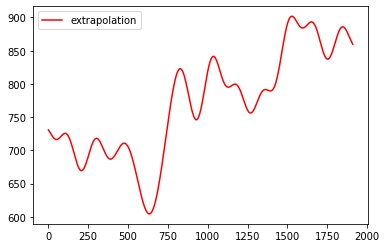

In [ ]:
x = one_ts['sales'].values
x = x[:1546]
n_predict = 1912 - 1546
extrapolation = fourierExtrapolation(x, n_predict)
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
# pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
pl.legend()
pl.show()

In [ ]:
one_ts['furier'] = extrapolation

In [ ]:
one_ts[['date','sales', 'furier']]

,date,sales,furier
0,2011-01-29,1083,730.809009
1,2011-01-30,926,730.469383
2,2011-01-31,684,730.118988
3,2011-02-01,455,729.758736
4,2011-02-02,132,729.389543
...,...,...,...
1907,2016-04-19,913,861.470159
1908,2016-04-20,846,861.024414
1909,2016-04-21,881,860.590574
1910,2016-04-22,1014,860.169113
